In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os 
import cv2
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
base_tile_dir = os.path.join('input', 'kather_texture_2016_image_tiles_5000')
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir, '*', '*.tif'))}) 
df['cell_type'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
df['cell_type_idx'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
df['image_name'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
df['image_row'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[1])
df['image_col'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[3].split('.')[0])
df['image'] = df['path'].map(imread)
df.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,image
2864,input\kather_texture_2016_image_tiles_5000\05_...,DEBRIS,05,2346_CRC-Prim-HE-03_010.tif,751,601,"[[[231, 203, 202], [242, 214, 213], [246, 221,..."
404,input\kather_texture_2016_image_tiles_5000\01_...,TUMOR,01,46D4_CRC-Prim-HE-07_023.tif,451,1,"[[[157, 71, 118], [172, 76, 121], [181, 85, 13..."
2074,input\kather_texture_2016_image_tiles_5000\04_...,LYMPHO,04,16C25_CRC-Prim-HE-01_004.tif,901,601,"[[[43, 8, 40], [56, 8, 40], [56, 8, 40], [50, ..."
3932,input\kather_texture_2016_image_tiles_5000\07_...,ADIPOSE,07,122DA_CRC-Prim-HE-05_032.tif,151,2251,"[[[240, 240, 240], [240, 240, 240], [240, 240,..."
4707,input\kather_texture_2016_image_tiles_5000\08_...,EMPTY,08,1310F_CRC-Prim-HE-06_005.tif,3601,6901,"[[[243, 242, 247], [243, 242, 247], [243, 242,..."


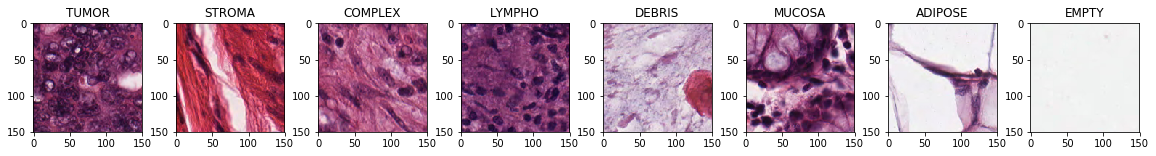

In [3]:
from random import randint

def get_first_cell_images(df):
    #get unique cell types
    unique_cell_type = df.cell_type.unique()
    cell_images = []
    for cell in unique_cell_type:
        #get the first row containing an image of cell_type == cell
        first_img_idx= np.where(df.cell_type == cell) 
        #list containing one image of each type
        cell_images.append((df[df.cell_type == cell].loc[first_img_idx[0][0],'image'], cell))
    return cell_images

images = get_first_cell_images(df)

#create the subplots
fig, m_axs = plt.subplots(1, len(images), figsize = (20, 2))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(images[ii][0])
    c_ax.set_title(images[ii][1])

In [4]:
from keras.preprocessing import image                  
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True     
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(150,150))
    # convert PIL.Image.Image type to 3D tensor with shape (150, 150, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 150, 150, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

images_path = list(df.path)

images_tensors = paths_to_tensor(images_path)

images_tensors.shape

Using TensorFlow backend.
100%|██████████| 5000/5000 [00:25<00:00, 193.11it/s]


(5000, 150, 150, 3)

In [5]:
df.cell_type.unique()

array(['TUMOR', 'STROMA', 'COMPLEX', 'LYMPHO', 'DEBRIS', 'MUCOSA',
       'ADIPOSE', 'EMPTY'], dtype=object)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils


train_fraction = 0.8

encoder = LabelBinarizer()
y = encoder.fit_transform(df.cell_type)
x = images_tensors

train_tensors, test_tensors, train_targets, test_targets =\
    train_test_split(x, y, train_size = train_fraction, random_state = 42)

val_size = int(0.5*len(test_tensors))

val_tensors = test_tensors[:val_size]
val_targets = test_targets[:val_size]
test_tensors = test_tensors[val_size:]
test_targets = test_targets[val_size:]

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from tensorflow import set_random_seed

set_random_seed(42)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = 3))
model.add(GlobalMaxPooling2D())
model.add(Dense(8, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 32)        9248      
__________

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 50
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=20, verbose=1, callbacks = [early_stopping, checkpointer])

Train on 4000 samples, validate on 500 samples
Epoch 1/50
4000/4000 [==============================] - ETA: 6:58 - loss: 4.3700 - acc: 0.050 - ETA: 4:15 - loss: 5.1794 - acc: 0.100 - ETA: 3:22 - loss: 4.1361 - acc: 0.133 - ETA: 2:55 - loss: 3.7296 - acc: 0.112 - ETA: 2:39 - loss: 3.4018 - acc: 0.110 - ETA: 2:29 - loss: 3.1826 - acc: 0.108 - ETA: 2:21 - loss: 3.0234 - acc: 0.135 - ETA: 2:15 - loss: 2.8999 - acc: 0.150 - ETA: 2:10 - loss: 2.8073 - acc: 0.150 - ETA: 2:05 - loss: 2.7221 - acc: 0.175 - ETA: 2:02 - loss: 2.7020 - acc: 0.163 - ETA: 1:59 - loss: 2.6493 - acc: 0.162 - ETA: 1:56 - loss: 2.6027 - acc: 0.161 - ETA: 1:54 - loss: 2.5604 - acc: 0.167 - ETA: 1:52 - loss: 2.5164 - acc: 0.170 - ETA: 1:50 - loss: 2.5379 - acc: 0.168 - ETA: 1:50 - loss: 2.5110 - acc: 0.164 - ETA: 1:48 - loss: 2.4846 - acc: 0.169 - ETA: 1:47 - loss: 2.4589 - acc: 0.173 - ETA: 1:45 - loss: 2.4267 - acc: 0.177 - ETA: 1:44 - loss: 2.4309 - acc: 0.176 - ETA: 1:43 - loss: 2.4136 - acc: 0.175 - ETA: 1:41 - loss:

4000/4000 [==============================] - ETA: 1:51 - loss: 1.8197 - acc: 0.250 - ETA: 1:59 - loss: 1.7346 - acc: 0.225 - ETA: 2:00 - loss: 1.7062 - acc: 0.250 - ETA: 1:59 - loss: 1.5965 - acc: 0.287 - ETA: 1:59 - loss: 1.5512 - acc: 0.300 - ETA: 1:55 - loss: 1.5496 - acc: 0.308 - ETA: 1:51 - loss: 1.5721 - acc: 0.300 - ETA: 1:49 - loss: 1.5991 - acc: 0.300 - ETA: 1:49 - loss: 1.6461 - acc: 0.294 - ETA: 1:52 - loss: 1.6351 - acc: 0.300 - ETA: 1:51 - loss: 1.6216 - acc: 0.300 - ETA: 1:48 - loss: 1.5893 - acc: 0.312 - ETA: 1:46 - loss: 1.5781 - acc: 0.319 - ETA: 1:44 - loss: 1.5683 - acc: 0.321 - ETA: 1:43 - loss: 1.6167 - acc: 0.313 - ETA: 1:41 - loss: 1.6259 - acc: 0.300 - ETA: 1:40 - loss: 1.6206 - acc: 0.320 - ETA: 1:38 - loss: 1.6097 - acc: 0.333 - ETA: 1:37 - loss: 1.5923 - acc: 0.331 - ETA: 1:37 - loss: 1.5809 - acc: 0.340 - ETA: 1:36 - loss: 1.5778 - acc: 0.340 - ETA: 1:35 - loss: 1.5650 - acc: 0.340 - ETA: 1:34 - loss: 1.5529 - acc: 0.347 - ETA: 1:33 - loss: 1.5444 - acc: 0.3

4000/4000 [==============================] - ETA: 1:33 - loss: 1.1478 - acc: 0.650 - ETA: 1:35 - loss: 1.0212 - acc: 0.575 - ETA: 1:34 - loss: 0.9907 - acc: 0.583 - ETA: 1:33 - loss: 1.0449 - acc: 0.562 - ETA: 1:32 - loss: 1.0385 - acc: 0.550 - ETA: 1:31 - loss: 0.9960 - acc: 0.583 - ETA: 1:30 - loss: 1.0008 - acc: 0.578 - ETA: 1:30 - loss: 1.0029 - acc: 0.575 - ETA: 1:29 - loss: 0.9868 - acc: 0.583 - ETA: 1:29 - loss: 0.9874 - acc: 0.580 - ETA: 1:28 - loss: 1.0052 - acc: 0.577 - ETA: 1:28 - loss: 1.0001 - acc: 0.579 - ETA: 1:27 - loss: 1.0018 - acc: 0.580 - ETA: 1:27 - loss: 1.0041 - acc: 0.575 - ETA: 1:26 - loss: 1.0252 - acc: 0.563 - ETA: 1:26 - loss: 1.0219 - acc: 0.568 - ETA: 1:26 - loss: 1.0162 - acc: 0.576 - ETA: 1:27 - loss: 1.0042 - acc: 0.580 - ETA: 1:26 - loss: 1.0003 - acc: 0.589 - ETA: 1:27 - loss: 1.0012 - acc: 0.587 - ETA: 1:27 - loss: 0.9837 - acc: 0.600 - ETA: 1:26 - loss: 0.9723 - acc: 0.606 - ETA: 1:25 - loss: 0.9901 - acc: 0.602 - ETA: 1:25 - loss: 1.0052 - acc: 0.5

4000/4000 [==============================] - ETA: 1:30 - loss: 1.2953 - acc: 0.550 - ETA: 1:31 - loss: 1.3407 - acc: 0.550 - ETA: 1:32 - loss: 1.4182 - acc: 0.483 - ETA: 1:32 - loss: 1.3112 - acc: 0.500 - ETA: 1:31 - loss: 1.2243 - acc: 0.540 - ETA: 1:31 - loss: 1.1313 - acc: 0.566 - ETA: 1:32 - loss: 1.0972 - acc: 0.578 - ETA: 1:32 - loss: 1.0829 - acc: 0.575 - ETA: 1:34 - loss: 1.1400 - acc: 0.561 - ETA: 1:34 - loss: 1.1359 - acc: 0.560 - ETA: 1:33 - loss: 1.0856 - acc: 0.586 - ETA: 1:32 - loss: 1.0357 - acc: 0.608 - ETA: 1:31 - loss: 1.0179 - acc: 0.615 - ETA: 1:31 - loss: 0.9965 - acc: 0.621 - ETA: 1:30 - loss: 1.0035 - acc: 0.630 - ETA: 1:29 - loss: 0.9995 - acc: 0.625 - ETA: 1:29 - loss: 0.9890 - acc: 0.629 - ETA: 1:28 - loss: 0.9710 - acc: 0.630 - ETA: 1:27 - loss: 0.9468 - acc: 0.634 - ETA: 1:27 - loss: 0.9402 - acc: 0.630 - ETA: 1:26 - loss: 0.9309 - acc: 0.635 - ETA: 1:25 - loss: 0.9314 - acc: 0.636 - ETA: 1:25 - loss: 0.9170 - acc: 0.641 - ETA: 1:24 - loss: 0.9272 - acc: 0.6

4000/4000 [==============================] - ETA: 1:48 - loss: 0.7023 - acc: 0.800 - ETA: 1:42 - loss: 0.8158 - acc: 0.700 - ETA: 1:38 - loss: 0.8897 - acc: 0.700 - ETA: 1:37 - loss: 0.8196 - acc: 0.700 - ETA: 1:35 - loss: 0.7328 - acc: 0.730 - ETA: 1:36 - loss: 0.7519 - acc: 0.725 - ETA: 1:36 - loss: 0.8677 - acc: 0.714 - ETA: 1:36 - loss: 0.8852 - acc: 0.712 - ETA: 1:36 - loss: 0.8676 - acc: 0.716 - ETA: 1:34 - loss: 0.8881 - acc: 0.705 - ETA: 1:33 - loss: 0.9205 - acc: 0.681 - ETA: 1:33 - loss: 0.9141 - acc: 0.683 - ETA: 1:32 - loss: 0.8931 - acc: 0.688 - ETA: 1:31 - loss: 0.8852 - acc: 0.696 - ETA: 1:31 - loss: 0.8675 - acc: 0.703 - ETA: 1:30 - loss: 0.8773 - acc: 0.700 - ETA: 1:29 - loss: 0.8857 - acc: 0.685 - ETA: 1:29 - loss: 0.9055 - acc: 0.677 - ETA: 1:28 - loss: 0.9222 - acc: 0.668 - ETA: 1:28 - loss: 0.9281 - acc: 0.667 - ETA: 1:27 - loss: 0.9122 - acc: 0.669 - ETA: 1:27 - loss: 0.8939 - acc: 0.679 - ETA: 1:26 - loss: 0.8921 - acc: 0.682 - ETA: 1:26 - loss: 0.8890 - acc: 0.6

4000/4000 [==============================] - ETA: 1:34 - loss: 0.4509 - acc: 0.850 - ETA: 1:33 - loss: 0.4901 - acc: 0.850 - ETA: 1:32 - loss: 0.5215 - acc: 0.833 - ETA: 1:32 - loss: 0.6491 - acc: 0.762 - ETA: 1:31 - loss: 0.7353 - acc: 0.730 - ETA: 1:31 - loss: 0.7271 - acc: 0.733 - ETA: 1:30 - loss: 0.6964 - acc: 0.750 - ETA: 1:29 - loss: 0.7236 - acc: 0.743 - ETA: 1:29 - loss: 0.6802 - acc: 0.766 - ETA: 1:29 - loss: 0.6478 - acc: 0.775 - ETA: 1:28 - loss: 0.6364 - acc: 0.777 - ETA: 1:27 - loss: 0.6510 - acc: 0.770 - ETA: 1:27 - loss: 0.6661 - acc: 0.761 - ETA: 1:28 - loss: 0.7029 - acc: 0.753 - ETA: 1:27 - loss: 0.6938 - acc: 0.753 - ETA: 1:27 - loss: 0.6989 - acc: 0.750 - ETA: 1:26 - loss: 0.7018 - acc: 0.747 - ETA: 1:26 - loss: 0.6952 - acc: 0.752 - ETA: 1:25 - loss: 0.6954 - acc: 0.750 - ETA: 1:25 - loss: 0.6811 - acc: 0.755 - ETA: 1:25 - loss: 0.6798 - acc: 0.754 - ETA: 1:25 - loss: 0.6909 - acc: 0.754 - ETA: 1:25 - loss: 0.6974 - acc: 0.754 - ETA: 1:24 - loss: 0.7158 - acc: 0.7

4000/4000 [==============================] - ETA: 1:33 - loss: 0.5276 - acc: 0.800 - ETA: 1:34 - loss: 0.4618 - acc: 0.800 - ETA: 1:32 - loss: 0.5794 - acc: 0.766 - ETA: 1:32 - loss: 0.6411 - acc: 0.737 - ETA: 1:32 - loss: 0.6772 - acc: 0.760 - ETA: 1:31 - loss: 0.6530 - acc: 0.766 - ETA: 1:30 - loss: 0.6498 - acc: 0.771 - ETA: 1:30 - loss: 0.6496 - acc: 0.756 - ETA: 1:29 - loss: 0.6974 - acc: 0.738 - ETA: 1:29 - loss: 0.7126 - acc: 0.735 - ETA: 1:30 - loss: 0.7477 - acc: 0.727 - ETA: 1:31 - loss: 0.7027 - acc: 0.741 - ETA: 1:31 - loss: 0.6939 - acc: 0.742 - ETA: 1:31 - loss: 0.7211 - acc: 0.735 - ETA: 1:30 - loss: 0.7334 - acc: 0.733 - ETA: 1:30 - loss: 0.7189 - acc: 0.737 - ETA: 1:29 - loss: 0.7062 - acc: 0.741 - ETA: 1:29 - loss: 0.7046 - acc: 0.741 - ETA: 1:28 - loss: 0.6975 - acc: 0.742 - ETA: 1:27 - loss: 0.6865 - acc: 0.745 - ETA: 1:27 - loss: 0.6724 - acc: 0.752 - ETA: 1:26 - loss: 0.6830 - acc: 0.747 - ETA: 1:26 - loss: 0.6826 - acc: 0.747 - ETA: 1:25 - loss: 0.6664 - acc: 0.7

4000/4000 [==============================] - ETA: 1:36 - loss: 0.5275 - acc: 0.800 - ETA: 1:43 - loss: 0.5121 - acc: 0.800 - ETA: 1:44 - loss: 0.5955 - acc: 0.750 - ETA: 1:43 - loss: 0.6100 - acc: 0.762 - ETA: 1:43 - loss: 0.6604 - acc: 0.740 - ETA: 1:41 - loss: 0.7005 - acc: 0.708 - ETA: 1:39 - loss: 0.6897 - acc: 0.721 - ETA: 1:39 - loss: 0.6305 - acc: 0.756 - ETA: 1:37 - loss: 0.6154 - acc: 0.744 - ETA: 1:36 - loss: 0.5942 - acc: 0.740 - ETA: 1:35 - loss: 0.5800 - acc: 0.750 - ETA: 1:34 - loss: 0.5744 - acc: 0.762 - ETA: 1:33 - loss: 0.6030 - acc: 0.750 - ETA: 1:32 - loss: 0.5993 - acc: 0.750 - ETA: 1:31 - loss: 0.6005 - acc: 0.750 - ETA: 1:30 - loss: 0.6059 - acc: 0.756 - ETA: 1:30 - loss: 0.6163 - acc: 0.750 - ETA: 1:29 - loss: 0.6010 - acc: 0.761 - ETA: 1:28 - loss: 0.6200 - acc: 0.752 - ETA: 1:28 - loss: 0.6286 - acc: 0.747 - ETA: 1:27 - loss: 0.6181 - acc: 0.750 - ETA: 1:27 - loss: 0.6307 - acc: 0.752 - ETA: 1:26 - loss: 0.6219 - acc: 0.754 - ETA: 1:26 - loss: 0.6157 - acc: 0.7

4000/4000 [==============================] - ETA: 1:33 - loss: 0.5307 - acc: 0.800 - ETA: 1:31 - loss: 0.8444 - acc: 0.725 - ETA: 1:33 - loss: 0.9278 - acc: 0.716 - ETA: 1:32 - loss: 0.8996 - acc: 0.687 - ETA: 1:31 - loss: 0.8171 - acc: 0.710 - ETA: 1:31 - loss: 0.7693 - acc: 0.733 - ETA: 1:30 - loss: 0.7980 - acc: 0.721 - ETA: 1:30 - loss: 0.8831 - acc: 0.731 - ETA: 1:30 - loss: 0.8365 - acc: 0.733 - ETA: 1:31 - loss: 0.8402 - acc: 0.730 - ETA: 1:30 - loss: 0.8066 - acc: 0.740 - ETA: 1:31 - loss: 0.7806 - acc: 0.745 - ETA: 1:30 - loss: 0.7524 - acc: 0.750 - ETA: 1:30 - loss: 0.7467 - acc: 0.742 - ETA: 1:29 - loss: 0.7346 - acc: 0.746 - ETA: 1:28 - loss: 0.7291 - acc: 0.750 - ETA: 1:28 - loss: 0.7269 - acc: 0.752 - ETA: 1:27 - loss: 0.7246 - acc: 0.747 - ETA: 1:26 - loss: 0.7170 - acc: 0.747 - ETA: 1:26 - loss: 0.7028 - acc: 0.750 - ETA: 1:25 - loss: 0.6963 - acc: 0.750 - ETA: 1:25 - loss: 0.6811 - acc: 0.756 - ETA: 1:24 - loss: 0.6597 - acc: 0.765 - ETA: 1:24 - loss: 0.6945 - acc: 0.7

4000/4000 [==============================] - ETA: 1:30 - loss: 0.5310 - acc: 0.750 - ETA: 1:31 - loss: 0.5254 - acc: 0.775 - ETA: 1:32 - loss: 0.4624 - acc: 0.833 - ETA: 1:32 - loss: 0.4384 - acc: 0.837 - ETA: 1:31 - loss: 0.4842 - acc: 0.810 - ETA: 1:30 - loss: 0.4716 - acc: 0.816 - ETA: 1:30 - loss: 0.4474 - acc: 0.821 - ETA: 1:29 - loss: 0.4386 - acc: 0.825 - ETA: 1:29 - loss: 0.4220 - acc: 0.827 - ETA: 1:29 - loss: 0.4353 - acc: 0.820 - ETA: 1:28 - loss: 0.5848 - acc: 0.809 - ETA: 1:28 - loss: 0.5922 - acc: 0.808 - ETA: 1:27 - loss: 0.5951 - acc: 0.807 - ETA: 1:26 - loss: 0.5864 - acc: 0.814 - ETA: 1:26 - loss: 0.6016 - acc: 0.803 - ETA: 1:25 - loss: 0.6006 - acc: 0.796 - ETA: 1:26 - loss: 0.6055 - acc: 0.791 - ETA: 1:26 - loss: 0.5927 - acc: 0.791 - ETA: 1:26 - loss: 0.5858 - acc: 0.794 - ETA: 1:26 - loss: 0.5860 - acc: 0.800 - ETA: 1:25 - loss: 0.5672 - acc: 0.807 - ETA: 1:25 - loss: 0.5599 - acc: 0.809 - ETA: 1:24 - loss: 0.5845 - acc: 0.808 - ETA: 1:24 - loss: 0.6296 - acc: 0.8

4000/4000 [==============================] - ETA: 1:33 - loss: 0.5974 - acc: 0.750 - ETA: 1:32 - loss: 0.6366 - acc: 0.750 - ETA: 1:32 - loss: 0.5804 - acc: 0.750 - ETA: 1:31 - loss: 0.4547 - acc: 0.812 - ETA: 1:31 - loss: 0.4271 - acc: 0.830 - ETA: 1:30 - loss: 0.3709 - acc: 0.850 - ETA: 1:30 - loss: 0.3997 - acc: 0.850 - ETA: 1:31 - loss: 0.4118 - acc: 0.843 - ETA: 1:32 - loss: 0.4438 - acc: 0.838 - ETA: 1:32 - loss: 0.5711 - acc: 0.815 - ETA: 1:33 - loss: 0.6103 - acc: 0.809 - ETA: 1:32 - loss: 0.5926 - acc: 0.812 - ETA: 1:31 - loss: 0.5770 - acc: 0.819 - ETA: 1:31 - loss: 0.5730 - acc: 0.821 - ETA: 1:30 - loss: 0.6012 - acc: 0.810 - ETA: 1:29 - loss: 0.5969 - acc: 0.809 - ETA: 1:29 - loss: 0.6062 - acc: 0.805 - ETA: 1:28 - loss: 0.5944 - acc: 0.811 - ETA: 1:27 - loss: 0.5776 - acc: 0.813 - ETA: 1:27 - loss: 0.5755 - acc: 0.810 - ETA: 1:26 - loss: 0.5711 - acc: 0.809 - ETA: 1:26 - loss: 0.5848 - acc: 0.809 - ETA: 1:25 - loss: 0.5801 - acc: 0.806 - ETA: 1:25 - loss: 0.5647 - acc: 0.8

4000/4000 [==============================] - ETA: 1:46 - loss: 0.5182 - acc: 0.900 - ETA: 1:40 - loss: 0.5207 - acc: 0.825 - ETA: 1:37 - loss: 0.5092 - acc: 0.816 - ETA: 1:36 - loss: 0.4684 - acc: 0.825 - ETA: 1:35 - loss: 0.4530 - acc: 0.820 - ETA: 1:33 - loss: 0.4906 - acc: 0.816 - ETA: 1:33 - loss: 0.5951 - acc: 0.828 - ETA: 1:33 - loss: 0.6117 - acc: 0.825 - ETA: 1:32 - loss: 0.6896 - acc: 0.816 - ETA: 1:32 - loss: 0.6615 - acc: 0.825 - ETA: 1:32 - loss: 0.6586 - acc: 0.818 - ETA: 1:32 - loss: 0.7003 - acc: 0.795 - ETA: 1:31 - loss: 0.6798 - acc: 0.803 - ETA: 1:30 - loss: 0.6528 - acc: 0.810 - ETA: 1:30 - loss: 0.6377 - acc: 0.816 - ETA: 1:30 - loss: 0.6393 - acc: 0.809 - ETA: 1:29 - loss: 0.6124 - acc: 0.817 - ETA: 1:28 - loss: 0.5942 - acc: 0.822 - ETA: 1:28 - loss: 0.6105 - acc: 0.813 - ETA: 1:28 - loss: 0.6091 - acc: 0.807 - ETA: 1:27 - loss: 0.6031 - acc: 0.809 - ETA: 1:27 - loss: 0.5852 - acc: 0.813 - ETA: 1:26 - loss: 0.5756 - acc: 0.817 - ETA: 1:26 - loss: 0.5658 - acc: 0.8

4000/4000 [==============================] - ETA: 1:33 - loss: 0.4019 - acc: 0.850 - ETA: 1:34 - loss: 0.3427 - acc: 0.875 - ETA: 1:33 - loss: 0.3666 - acc: 0.850 - ETA: 1:32 - loss: 1.1566 - acc: 0.825 - ETA: 1:32 - loss: 0.9924 - acc: 0.840 - ETA: 1:32 - loss: 0.8640 - acc: 0.850 - ETA: 1:31 - loss: 0.9180 - acc: 0.835 - ETA: 1:30 - loss: 0.9013 - acc: 0.812 - ETA: 1:30 - loss: 0.8317 - acc: 0.827 - ETA: 1:29 - loss: 0.7951 - acc: 0.830 - ETA: 1:29 - loss: 1.0771 - acc: 0.809 - ETA: 1:28 - loss: 1.0529 - acc: 0.800 - ETA: 1:28 - loss: 1.0010 - acc: 0.807 - ETA: 1:27 - loss: 0.9507 - acc: 0.814 - ETA: 1:27 - loss: 0.8993 - acc: 0.823 - ETA: 1:26 - loss: 0.8746 - acc: 0.825 - ETA: 1:26 - loss: 0.8600 - acc: 0.820 - ETA: 1:25 - loss: 0.8448 - acc: 0.816 - ETA: 1:25 - loss: 0.8262 - acc: 0.818 - ETA: 1:24 - loss: 0.8406 - acc: 0.810 - ETA: 1:24 - loss: 0.8151 - acc: 0.811 - ETA: 1:23 - loss: 0.8072 - acc: 0.813 - ETA: 1:23 - loss: 0.7881 - acc: 0.813 - ETA: 1:23 - loss: 0.7714 - acc: 0.8

4000/4000 [==============================] - ETA: 1:33 - loss: 0.1015 - acc: 1.000 - ETA: 1:34 - loss: 0.1315 - acc: 0.950 - ETA: 1:33 - loss: 0.1796 - acc: 0.933 - ETA: 1:32 - loss: 0.2064 - acc: 0.925 - ETA: 1:31 - loss: 0.2608 - acc: 0.900 - ETA: 1:31 - loss: 0.3233 - acc: 0.891 - ETA: 1:31 - loss: 0.3925 - acc: 0.864 - ETA: 1:31 - loss: 0.4199 - acc: 0.868 - ETA: 1:30 - loss: 0.4417 - acc: 0.866 - ETA: 1:30 - loss: 0.4919 - acc: 0.870 - ETA: 1:29 - loss: 0.4866 - acc: 0.877 - ETA: 1:29 - loss: 0.6037 - acc: 0.854 - ETA: 1:28 - loss: 0.6472 - acc: 0.834 - ETA: 1:29 - loss: 0.6474 - acc: 0.835 - ETA: 1:29 - loss: 0.6407 - acc: 0.830 - ETA: 1:29 - loss: 0.6232 - acc: 0.834 - ETA: 1:29 - loss: 0.6137 - acc: 0.823 - ETA: 1:28 - loss: 0.5975 - acc: 0.833 - ETA: 1:28 - loss: 0.5821 - acc: 0.834 - ETA: 1:27 - loss: 0.5761 - acc: 0.840 - ETA: 1:27 - loss: 0.5607 - acc: 0.842 - ETA: 1:26 - loss: 0.5899 - acc: 0.834 - ETA: 1:25 - loss: 0.5883 - acc: 0.830 - ETA: 1:25 - loss: 0.5975 - acc: 0.8

4000/4000 [==============================] - ETA: 1:42 - loss: 0.3760 - acc: 0.850 - ETA: 1:38 - loss: 0.3211 - acc: 0.850 - ETA: 1:36 - loss: 0.4563 - acc: 0.800 - ETA: 1:34 - loss: 0.3962 - acc: 0.837 - ETA: 1:33 - loss: 0.3709 - acc: 0.850 - ETA: 1:34 - loss: 0.3900 - acc: 0.833 - ETA: 1:36 - loss: 0.3824 - acc: 0.828 - ETA: 1:37 - loss: 0.3604 - acc: 0.837 - ETA: 1:37 - loss: 0.3902 - acc: 0.827 - ETA: 1:35 - loss: 0.5934 - acc: 0.800 - ETA: 1:34 - loss: 0.5784 - acc: 0.809 - ETA: 1:33 - loss: 0.5670 - acc: 0.808 - ETA: 1:32 - loss: 0.5621 - acc: 0.803 - ETA: 1:31 - loss: 0.5647 - acc: 0.803 - ETA: 1:31 - loss: 0.5670 - acc: 0.803 - ETA: 1:30 - loss: 0.5632 - acc: 0.806 - ETA: 1:29 - loss: 0.5491 - acc: 0.811 - ETA: 1:28 - loss: 0.5341 - acc: 0.813 - ETA: 1:28 - loss: 0.5431 - acc: 0.810 - ETA: 1:27 - loss: 0.5377 - acc: 0.812 - ETA: 1:27 - loss: 0.5629 - acc: 0.807 - ETA: 1:26 - loss: 0.5644 - acc: 0.806 - ETA: 1:25 - loss: 0.5609 - acc: 0.806 - ETA: 1:25 - loss: 0.5669 - acc: 0.8

4000/4000 [==============================] - ETA: 1:33 - loss: 0.3527 - acc: 0.850 - ETA: 1:34 - loss: 0.5730 - acc: 0.800 - ETA: 1:33 - loss: 0.4942 - acc: 0.833 - ETA: 1:33 - loss: 0.5258 - acc: 0.825 - ETA: 1:32 - loss: 0.4655 - acc: 0.840 - ETA: 1:31 - loss: 0.4736 - acc: 0.841 - ETA: 1:31 - loss: 0.4535 - acc: 0.857 - ETA: 1:30 - loss: 0.4682 - acc: 0.837 - ETA: 1:29 - loss: 0.4557 - acc: 0.838 - ETA: 1:29 - loss: 0.4620 - acc: 0.825 - ETA: 1:29 - loss: 0.4647 - acc: 0.822 - ETA: 1:28 - loss: 0.5147 - acc: 0.820 - ETA: 1:28 - loss: 0.5643 - acc: 0.784 - ETA: 1:27 - loss: 0.6004 - acc: 0.778 - ETA: 1:27 - loss: 0.5845 - acc: 0.783 - ETA: 1:26 - loss: 0.5852 - acc: 0.781 - ETA: 1:26 - loss: 0.5712 - acc: 0.788 - ETA: 1:25 - loss: 0.5560 - acc: 0.794 - ETA: 1:25 - loss: 0.5404 - acc: 0.800 - ETA: 1:24 - loss: 0.5422 - acc: 0.800 - ETA: 1:24 - loss: 0.5350 - acc: 0.802 - ETA: 1:24 - loss: 0.5214 - acc: 0.802 - ETA: 1:23 - loss: 0.5486 - acc: 0.802 - ETA: 1:23 - loss: 0.5879 - acc: 0.7

4000/4000 [==============================] - ETA: 1:35 - loss: 0.5292 - acc: 0.900 - ETA: 1:36 - loss: 0.7528 - acc: 0.800 - ETA: 1:37 - loss: 0.6750 - acc: 0.833 - ETA: 1:44 - loss: 0.5823 - acc: 0.850 - ETA: 1:45 - loss: 0.5005 - acc: 0.870 - ETA: 1:43 - loss: 0.4658 - acc: 0.875 - ETA: 1:42 - loss: 0.5145 - acc: 0.857 - ETA: 1:41 - loss: 0.4968 - acc: 0.856 - ETA: 1:39 - loss: 0.4946 - acc: 0.850 - ETA: 1:38 - loss: 0.4855 - acc: 0.850 - ETA: 1:38 - loss: 0.4738 - acc: 0.854 - ETA: 1:38 - loss: 0.4556 - acc: 0.854 - ETA: 1:43 - loss: 0.4706 - acc: 0.853 - ETA: 1:43 - loss: 0.4736 - acc: 0.853 - ETA: 1:43 - loss: 0.4731 - acc: 0.846 - ETA: 1:42 - loss: 0.4748 - acc: 0.850 - ETA: 1:40 - loss: 0.4967 - acc: 0.847 - ETA: 1:39 - loss: 0.5310 - acc: 0.841 - ETA: 1:38 - loss: 0.5563 - acc: 0.831 - ETA: 1:37 - loss: 0.5879 - acc: 0.827 - ETA: 1:36 - loss: 0.5947 - acc: 0.823 - ETA: 1:35 - loss: 0.5834 - acc: 0.822 - ETA: 1:34 - loss: 0.5900 - acc: 0.819 - ETA: 1:33 - loss: 0.5760 - acc: 0.8

4000/4000 [==============================] - ETA: 1:41 - loss: 1.1606 - acc: 0.500 - ETA: 1:38 - loss: 2.4223 - acc: 0.500 - ETA: 1:38 - loss: 1.9005 - acc: 0.566 - ETA: 1:36 - loss: 1.5939 - acc: 0.600 - ETA: 1:35 - loss: 1.4194 - acc: 0.630 - ETA: 1:34 - loss: 1.2756 - acc: 0.658 - ETA: 1:34 - loss: 1.2026 - acc: 0.678 - ETA: 1:33 - loss: 1.1075 - acc: 0.700 - ETA: 1:34 - loss: 1.0526 - acc: 0.716 - ETA: 1:33 - loss: 0.9708 - acc: 0.735 - ETA: 1:33 - loss: 0.9686 - acc: 0.745 - ETA: 1:32 - loss: 0.9420 - acc: 0.737 - ETA: 1:31 - loss: 0.8946 - acc: 0.746 - ETA: 1:31 - loss: 0.8458 - acc: 0.757 - ETA: 1:30 - loss: 0.8470 - acc: 0.756 - ETA: 1:30 - loss: 0.8271 - acc: 0.762 - ETA: 1:29 - loss: 0.8076 - acc: 0.764 - ETA: 1:29 - loss: 0.7872 - acc: 0.769 - ETA: 1:29 - loss: 0.7703 - acc: 0.771 - ETA: 1:29 - loss: 0.7758 - acc: 0.777 - ETA: 1:29 - loss: 0.7626 - acc: 0.781 - ETA: 1:29 - loss: 0.7419 - acc: 0.786 - ETA: 1:28 - loss: 0.7348 - acc: 0.782 - ETA: 1:27 - loss: 0.7124 - acc: 0.7

4000/4000 [==============================] - ETA: 1:55 - loss: 0.5551 - acc: 0.750 - ETA: 1:47 - loss: 0.4795 - acc: 0.850 - ETA: 1:49 - loss: 0.4875 - acc: 0.850 - ETA: 1:45 - loss: 0.4715 - acc: 0.837 - ETA: 1:42 - loss: 0.4608 - acc: 0.840 - ETA: 1:41 - loss: 0.4749 - acc: 0.841 - ETA: 1:39 - loss: 0.5048 - acc: 0.821 - ETA: 1:39 - loss: 0.5164 - acc: 0.812 - ETA: 1:39 - loss: 0.5802 - acc: 0.800 - ETA: 1:39 - loss: 0.5742 - acc: 0.795 - ETA: 1:38 - loss: 0.5740 - acc: 0.795 - ETA: 1:38 - loss: 0.5597 - acc: 0.804 - ETA: 1:38 - loss: 0.5607 - acc: 0.807 - ETA: 1:37 - loss: 0.5698 - acc: 0.803 - ETA: 1:36 - loss: 0.5455 - acc: 0.813 - ETA: 1:35 - loss: 0.5220 - acc: 0.825 - ETA: 1:34 - loss: 0.5222 - acc: 0.820 - ETA: 1:34 - loss: 0.5460 - acc: 0.816 - ETA: 1:33 - loss: 0.5585 - acc: 0.813 - ETA: 1:32 - loss: 0.5627 - acc: 0.812 - ETA: 1:31 - loss: 0.5715 - acc: 0.809 - ETA: 1:31 - loss: 0.5575 - acc: 0.815 - ETA: 1:30 - loss: 0.5585 - acc: 0.813 - ETA: 1:29 - loss: 0.5475 - acc: 0.8

In [14]:
model.load_weights('weights.hdf5')

cell_predictions =  [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(cell_predictions)==np.argmax(test_targets, axis=1))/len(cell_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 74.8000%
